# Layer Experiment with Qwen3-0.6b

This notebook experiments with the smaller Qwen3-0.6b model (0.6b parameters, 28 layers) and tests how different layers affect LRE faithfulness.

In [ ]:
import json
import random
from lre import LREModel
from sklearn.model_selection import LeaveOneOut
import numpy as np
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
from IPython.display import display
import os
from data_utils import (
    load_json_files, 
    create_data_file_dropdown, 
    create_model_dropdown, 
    load_model_options, 
    fetch_model_layer_info,
    load_and_split_data,
    configure_template_and_print_summary,
    initialize_lre_model,
    get_layers_to_test,
    run_layer_experiment,
    plot_operator_eigenvalue_spectrum,
    plot_operator_svd_analysis,
    plot_pca_predictions,
    plot_pc1_projection_lines
)
import matplotlib.pyplot as plt

data_root = "data"
# Get all JSON files from all subdirectories under data/
json_files = load_json_files(data_root=data_root)

# Create dropdown for selecting a data file
data_file_dropdown = create_data_file_dropdown(json_files)
model_dropdown = create_model_dropdown(default_model="Qwen/Qwen3-0.6B")

# Fetch model layer info directly from model_config.json
models = load_model_options()
model_info = fetch_model_layer_info(
    models=models,
    output_file="model_layer_info.json",
    verbose=True
)

display(data_file_dropdown)
display(model_dropdown)

Found 47 relation files:
google/gemma-3-270m                      | Layers: 18   | Type: gemma3_text
google/gemma-3-1b-pt                     | Layers: 26   | Type: gemma3_text
gpt2                                     | Layers: 12   | Type: gpt2
gpt2-xl                                  | Layers: 48   | Type: gpt2
meta-llama/Llama-3.2-1B                  | Layers: 16   | Type: llama
mistralai/Mistral-7B-v0.3                | Layers: 32   | Type: mistral
Qwen/Qwen3-0.6B                          | Layers: 28   | Type: qwen3
Qwen/Qwen3-1.7B                          | Layers: 28   | Type: qwen3
Qwen/Qwen3-4B                            | Layers: 36   | Type: qwen3
Qwen/Qwen3-8B                            | Layers: 36   | Type: qwen3
Qwen/Qwen3-14B                           | Layers: 40   | Type: qwen3

Model information saved to: model_layer_info.json


Dropdown(description='Data File:', options=('bias/characteristic_gender.json', 'bias/degree_gender.json', 'bia…

Dropdown(description='Model:', index=6, options=('google/gemma-3-270m', 'google/gemma-3-1b-pt', 'gpt2', 'gpt2-…

## 2. Load and Split Data Initialise model



In [6]:
# Initialize LRE model

MODEL_NAME = model_dropdown.value
lre = initialize_lre_model(MODEL_NAME, device="mps") # or "cuda" if GPU is available 

DATA_FILE = os.path.join(data_root, data_file_dropdown.value)
print(f"\nSelected data file: {DATA_FILE}")

# Load and split data using utility function
result = load_and_split_data(DATA_FILE, train_ratio=0.6, seed=42)

train_data = result['train_data']
test_data = result['test_data']

# Configuration for few-shot learning - use all training data
K_FOLD_SIZE = len(train_data)

# Configure template and print summary
TEMPLATE = configure_template_and_print_summary(result, default_template="{} is commonly associated with")

Selected model: Qwen/Qwen3-0.6B
No HF_TOKEN found - proceeding without authentication
Loading Qwen/Qwen3-0.6B on mps...

Selected data file: data/bias/characteristic_gender.json
Dataset: characteristic gender
Template: {} is commonly associated with
Data: 18 train, 12 test


## 4. Layer-by-Layer Experiment to determine the best layer

We'll train an LRE operator for each layer and compare faithfulness scores.
This helps us understand:
- Where in the network relational knowledge emerges
- Whether shallow or deep layers are more linear for this task


In [7]:
# Layer-by-Layer Experiment - Testing different layers on test set

# Automatically determine layers to test based on model metadata
LAYERS_TO_TEST = get_layers_to_test(
    MODEL_NAME, 
    model_info=model_info,
    start_offset=0,  # Skip first 3 layers
    end_offset=0,    # Skip last 3 layers
    step=1           # Test every layer (use step=2 for every other layer, etc.)
)

# Run the layer experiment
experiment_results = run_layer_experiment(
    lre_model=lre,
    train_data=train_data,
    test_data=test_data,
    layers_to_test=LAYERS_TO_TEST,
    template=TEMPLATE,
    visualize=True
)

# Extract results for later use
results = experiment_results['results']
faithfulness_scores = experiment_results['faithfulness_scores']
best_layer = experiment_results['best_layer']
best_faithfulness = experiment_results['best_faithfulness']

# Store few_shot_template_full for later evaluation
few_shot_examples_full = "\n".join([
    TEMPLATE.format(sample['subject']) + f" {sample['object']}."
    for sample in train_data
])
few_shot_template_full = few_shot_examples_full + "\n" + TEMPLATE

Model: Qwen/Qwen3-0.6B
  Type: qwen3
  Total layers: 28
  Layer prefix: model.layers
  Testing layers 0 to 27 (step=1)
  Total layers to test: 28

TESTING LAYER 0

Evaluating Layer 0 on test set:

                               EVALUATION RESULTS                               

Sample prompt structure (first test item):
────────────────────────────────────────────────────────────────────────────────
multitasking is commonly associated with women.
aggressiveness is commonly associated with men.
flexibility is commonly associated with women.
bravery is commonly associated with men.
ambition is commonly associated with men.
assertiveness is commonly associated with men.
creativity is commonly associated with women.
logical thinking is commonly associated with men.
sensitivity is commonly associated with women.
nurturing is commonly associated with women.
persuasiveness is commonly associated with men.
critical thinking is commonly associated with men.
endurance is commonly associated with

KeyboardInterrupt: 

In [11]:
print(f"Best Layer: {best_layer}")
print(f"Best Faithfulness Score: {best_faithfulness:.4f}")

Best Layer: model.layers.13
Best Faithfulness Score: 0.7500


In [12]:
# Extract the best operator from the layer-by-layer experiment
best_operator = results[best_layer]

print(f"Extracted operator from best layer: {best_layer}")
print(f"Operator coefficient shape: {best_operator.coef_.shape}")
print(f"Operator intercept shape: {best_operator.intercept_.shape}")

# Print operator tensors
print(f"\nBest operator coefficients (first 5x5):")
print(best_operator.coef_[:5, :5])

print(f"\nBest operator intercept (first 10):")
print(best_operator.intercept_[:10])

Extracted operator from best layer: model.layers.13
Operator coefficient shape: (1024, 1024)
Operator intercept shape: (1024,)

Best operator coefficients (first 5x5):
[[-5.65655209e-05 -2.64000687e-06 -3.44306973e-05  8.02267750e-05
  -2.64710743e-05]
 [ 1.06238906e-04  4.95831955e-06  6.46662811e-05 -1.50678534e-04
   4.97168221e-05]
 [ 4.03438935e-05  1.88290824e-06  2.45567935e-05 -5.72197023e-05
   1.88798203e-05]
 [-1.16997318e-04 -5.46031924e-06 -7.12147448e-05  1.65937134e-04
  -5.47514574e-05]
 [-7.26190119e-05 -3.38920836e-06 -4.42022356e-05  1.02995451e-04
  -3.39836697e-05]]

Best operator intercept (first 10):
[-0.00165358 -0.04895286 -0.01581143  0.05388539 -0.061432   -0.05195712
  0.00087846 -0.00355072  0.02763216 -0.00777122]


In [13]:
# Evaluate the best operator on test set and store detailed results
test_eval_results = lre.evaluate(
    best_operator, 
    test_data, 
    best_layer, 
    few_shot_template_full
)


                               EVALUATION RESULTS                               

Sample prompt structure (first test item):
────────────────────────────────────────────────────────────────────────────────
multitasking is commonly associated with women.
aggressiveness is commonly associated with men.
flexibility is commonly associated with women.
bravery is commonly associated with men.
ambition is commonly associated with men.
assertiveness is commonly associated with men.
creativity is commonly associated with women.
logical thinking is commonly associated with men.
sensitivity is commonly associated with women.
nurturing is commonly associated with women.
persuasiveness is commonly associated with men.
critical thinking is commonly associated with men.
endurance is commonly associated with men.
discipline is commonly associated with men.
resilience is commonly associated with men.
adaptability is commonly associated with women.
confidence is commonly associated with men.
competitiv

/var/folders/w6/fwzthwpn2418wlm8l17t88wm0000gn/T/ipykernel_30814/2390852326.py:53: RuntimeWarning: divide by zero encountered in divide
  eigenvalue_ratios = eigenvalues_sorted[:-1] / eigenvalues_sorted[1:]
/var/folders/w6/fwzthwpn2418wlm8l17t88wm0000gn/T/ipykernel_30814/2390852326.py:53: RuntimeWarning: invalid value encountered in divide
  eigenvalue_ratios = eigenvalues_sorted[:-1] / eigenvalues_sorted[1:]


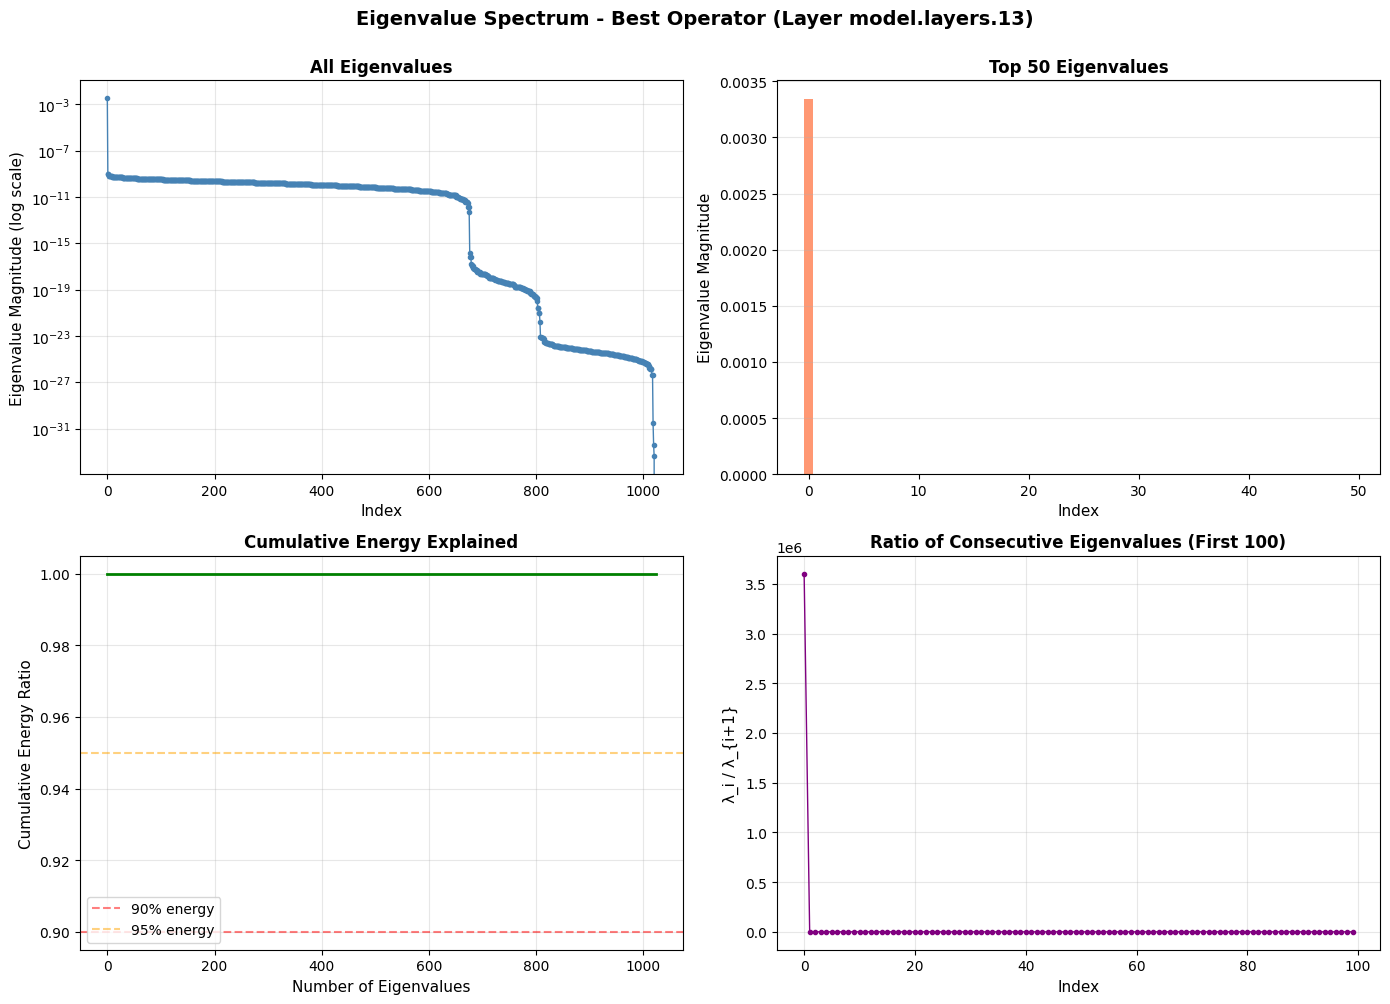


EIGENVALUE SPECTRUM STATISTICS
Total number of eigenvalues: 1024
Largest eigenvalue: 3.341571e-03
Smallest eigenvalue: 0.000000e+00
Condition number: inf

Top 10 eigenvalues:
  λ_1: 3.341571e-03
  λ_2: 9.277727e-10
  λ_3: 9.277727e-10
  λ_4: 6.953847e-10
  λ_5: 6.953847e-10
  λ_6: 6.928500e-10
  λ_7: 6.928500e-10
  λ_8: 6.323394e-10
  λ_9: 6.323394e-10
  λ_10: 5.790401e-10

Effective rank (90% energy): 1
Effective rank (95% energy): 1


/var/folders/w6/fwzthwpn2418wlm8l17t88wm0000gn/T/ipykernel_30814/2390852326.py:72: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Condition number: {eigenvalues_sorted[0] / eigenvalues_sorted[-1]:.6e}")


In [14]:
# Plot eigenvalue spectrum for best operator
eigenvalues = plot_operator_eigenvalue_spectrum(
    best_operator, 
    title=f"Eigenvalue Spectrum - Best Operator (Layer {best_layer})"
)

In [ ]:
# PCA analysis using the utility function

# Automatically detect classes from evaluation results
unique_classes = sorted(set(result['expected'] for result in test_eval_results['eval_results']))
class1_label = unique_classes[0] if len(unique_classes) > 0 else 'class1'
class2_label = unique_classes[1] if len(unique_classes) > 1 else 'class2'

print(f"Detected classes: {class1_label} and {class2_label}")

pca_results = plot_pca_predictions(
    test_eval_results, 
    class1_label=class1_label, 
    class2_label=class2_label,
    title_prefix=f'{result["dataset_name"]} Analysis'
)

# Store results for further analysis
pca = pca_results['pca']
predictions_pca = pca_results['predictions_pca']
men_pca = pca_results['class1_pca']
women_pca = pca_results['class2_pca']
men_predictions = pca_results['class1_predictions']
women_predictions = pca_results['class2_predictions']

In [ ]:
# Multi-Dataset, Multi-Model Experiment: Run analysis across different datasets and Qwen models

# Define datasets to test
bias_datasets = [
    "bias/occupation_age.json",
    "bias/degree_gender.json",
    "bias/characteristic_gender.json"
]

# Define models to test
qwen_models = [
    "Qwen/Qwen3-0.6B",
    "Qwen/Qwen3-1.7B",
    "Qwen/Qwen3-4B", 
    "Qwen/Qwen3-8B", 
    "Qwen/Qwen3-14B"
]

# Storage for all results across datasets and models
all_results = {}
best_layers_summary = {}  # Store just the best layers for easy access

for dataset_file in bias_datasets:
    print(f"\n{'#'*100}")
    print(f"{'#'*100}")
    print(f"PROCESSING DATASET: {dataset_file}")
    print(f"{'#'*100}")
    print(f"{'#'*100}\n")
    
    # Load and split data for this dataset
    DATA_FILE = os.path.join(data_root, dataset_file)
    print(f"Selected data file: {DATA_FILE}")
    
    result = load_and_split_data(DATA_FILE, train_ratio=0.6, seed=42)
    train_data = result['train_data']
    test_data = result['test_data']
    
    # Configure template
    TEMPLATE = configure_template_and_print_summary(result, default_template="{} is commonly associated with")
    
    # Storage for this dataset's model results
    dataset_model_results = {}
    best_layers_summary[dataset_file] = {}  # Initialize for this dataset
    
    for model_name in qwen_models:
        print(f"\n{'='*100}")
        print(f"PROCESSING MODEL: {model_name}")
        print(f"{'='*100}")
        
        # Initialize LRE model
        lre_current = initialize_lre_model(model_name, device="mps")
        
        # Get layers to test for this model
        layers_to_test_current = get_layers_to_test(
            model_name,
            model_info=model_info,
            start_offset=0,
            end_offset=0,
            step=1
        )
        
        # Run layer experiment
        experiment_results_current = run_layer_experiment(
            lre_model=lre_current,
            train_data=train_data,
            test_data=test_data,
            layers_to_test=layers_to_test_current,
            template=TEMPLATE,
            visualize=False  # Suppress individual plots
        )
        
        # Extract best operator
        best_layer_current = experiment_results_current['best_layer']
        best_operator_current = experiment_results_current['results'][best_layer_current]
        best_faithfulness_current = experiment_results_current['best_faithfulness']
        
        # Evaluate on test set
        few_shot_examples_full = "\n".join([
            TEMPLATE.format(sample['subject']) + f" {sample['object']}."
            for sample in train_data
        ])
        few_shot_template_current = few_shot_examples_full + "\n" + TEMPLATE
        
        test_eval_current = lre_current.evaluate(
            best_operator_current,
            test_data,
            best_layer_current,
            few_shot_template_current
        )
        
        # Store results
        dataset_model_results[model_name] = {
            'best_layer': best_layer_current,
            'best_operator': best_operator_current,
            'best_faithfulness': best_faithfulness_current,
            'faithfulness_scores': experiment_results_current['faithfulness_scores'],
            'test_eval_results': test_eval_current,
            'operator_coef': best_operator_current.coef_,
            'operator_intercept': best_operator_current.intercept_
        }
        
        # Store best layer in summary (without the operator objects for cleaner export)
        best_layers_summary[dataset_file][model_name] = {
            'best_layer': best_layer_current,
            'best_faithfulness': best_faithfulness_current
        }
        
        print(f"\n✓ Model {model_name} completed")
        print(f"  Best layer: {best_layer_current}")
        print(f"  Best faithfulness: {best_faithfulness_current:.4f}")
    
    # Store results for this dataset
    all_results[dataset_file] = {
        'model_results': dataset_model_results,
        'train_data': train_data,
        'test_data': test_data,
        'template': TEMPLATE,
        'dataset_info': result
    }
    
    # Summary for this dataset
    print(f"\n{'='*100}")
    print(f"DATASET {dataset_file} - MODEL COMPARISON SUMMARY")
    print(f"{'='*100}")
    print(f"{'Model':<30} {'Best Layer':<20} {'Faithfulness':<15}")
    print("-" * 100)
    for model_name in qwen_models:
        results = dataset_model_results[model_name]
        print(f"{model_name:<30} {results['best_layer']:<20} {results['best_faithfulness']:<15.4f}")

# Final cross-dataset summary
print(f"\n{'#'*100}")
print(f"{'#'*100}")
print("CROSS-DATASET COMPARISON SUMMARY")
print(f"{'#'*100}")
print(f"{'#'*100}\n")

for dataset_file in bias_datasets:
    print(f"\n{'='*100}")
    print(f"Dataset: {dataset_file}")
    print(f"{'='*100}")
    print(f"{'Model':<30} {'Best Layer':<20} {'Faithfulness':<15}")
    print("-" * 100)
    
    for model_name in qwen_models:
        results = all_results[dataset_file]['model_results'][model_name]
        print(f"{model_name:<30} {results['best_layer']:<20} {results['best_faithfulness']:<15.4f}")

# Save best layers summary to JSON file
import json
best_layers_filename = "best_layers_summary.json"
with open(best_layers_filename, 'w') as f:
    json.dump(best_layers_summary, f, indent=2)

print(f"\n{'#'*100}")
print(f"Results stored in 'all_results' dictionary")
print(f"Access via: all_results[dataset_file]['model_results'][model_name]")
print(f"\nBest layers summary stored in 'best_layers_summary' dictionary")
print(f"Access via: best_layers_summary[dataset_file][model_name]")
print(f"\nBest layers saved to: {best_layers_filename}")
print(f"{'#'*100}")

# Create a pandas DataFrame for easy viewing
import pandas as pd

# Prepare data for DataFrame
summary_data = []
for dataset_file in bias_datasets:
    for model_name in qwen_models:
        summary_data.append({
            'Dataset': dataset_file.replace('bias/', '').replace('.json', ''),
            'Model': model_name,
            'Best Layer': best_layers_summary[dataset_file][model_name]['best_layer'],
            'Faithfulness': best_layers_summary[dataset_file][model_name]['best_faithfulness']
        })

best_layers_df = pd.DataFrame(summary_data)

# Display the DataFrame
print(f"\n{'='*100}")
print("BEST LAYERS DATAFRAME")
print(f"{'='*100}")
print(best_layers_df.to_string(index=False))

# Save to CSV
csv_filename = "best_layers_summary.csv"
best_layers_df.to_csv(csv_filename, index=False)
print(f"\nDataFrame saved to: {csv_filename}")


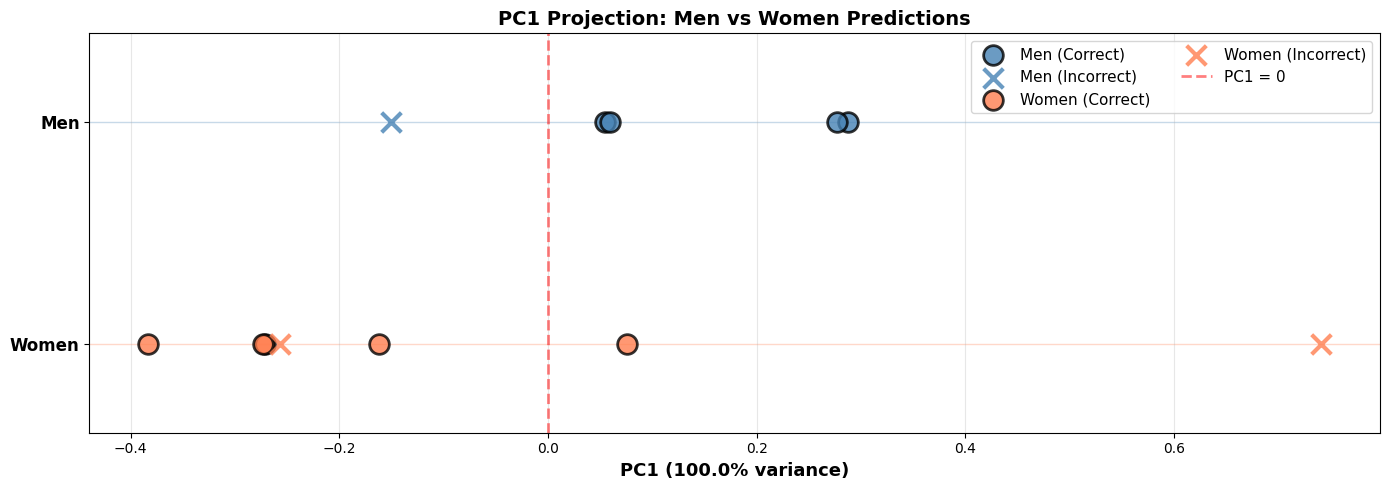


PC1 Statistics:

Men predictions (correct):
  [0] risk-taking: 0.2880
  [1] leadership: 0.2766
  [3] decisiveness: 0.0551
  [6] adventurousness: 0.0593

Men predictions (incorrect):
  [7] independence: -0.1506

Women predictions (correct):
  [5] humility: 0.0762
  [8] generosity: -0.1617
  [9] empathy: -0.3832
  [10] compassion: -0.2717
  [11] intuition: -0.2728

Women predictions (incorrect):
  [2] meticulousness: 0.7412
  [4] patience: -0.2564

Mean PC1 (Men): 0.2209
Mean PC1 (Women): -0.1578
Separation: 0.3787


In [ ]:
# PC1 2-line projection visualization using utility function

# Detect classes automatically
unique_classes = sorted(set(result['expected'] for result in test_eval_results['eval_results']))
class1_label = unique_classes[0] if len(unique_classes) > 0 else 'class1'
class2_label = unique_classes[1] if len(unique_classes) > 1 else 'class2'

pc1_stats = plot_pc1_projection_lines(
    test_eval_results,
    pca_results,
    class1_label=class1_label,
    class2_label=class2_label,
    title='PC1 Projection'
)


Most dominant component in PC1:
  Index: 622
  Loading value: 0.102774
  Absolute value: 0.102774

Top 10 most dominant components in PC1:
Rank   Index    Loading         |Loading|      
--------------------------------------------------
1      622      0.102774        0.102774       
2      456      0.095163        0.095163       
3      26       0.095096        0.095096       
4      85       0.090516        0.090516       
5      706      0.089169        0.089169       
6      661      0.086745        0.086745       
7      899      -0.084185       0.084185       
8      824      -0.083781       0.083781       
9      702      0.083243        0.083243       
10     429      0.082973        0.082973       


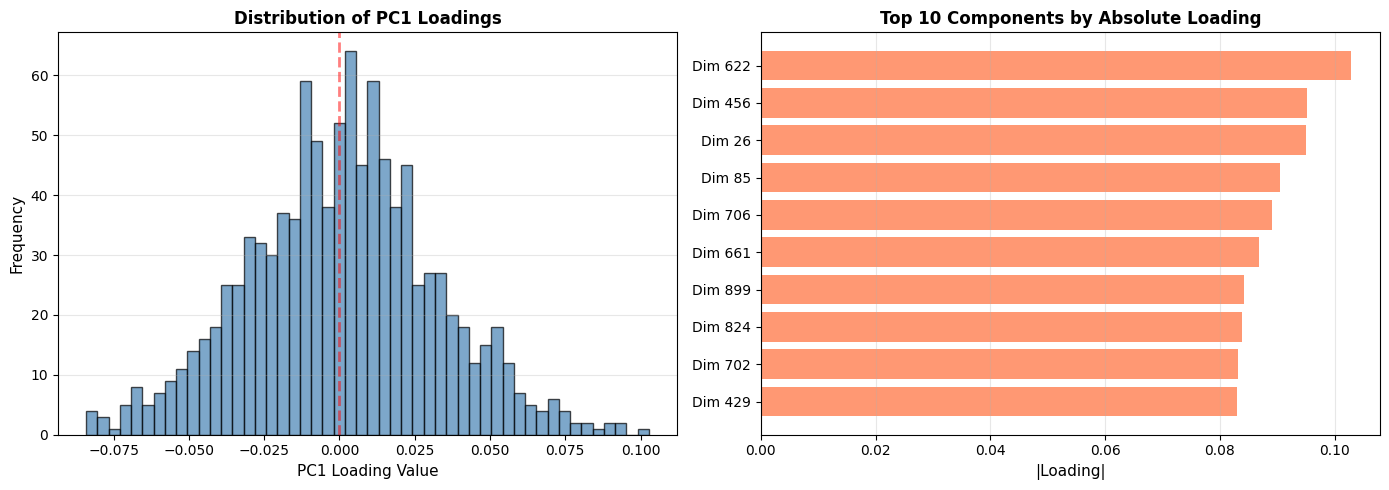


Cumulative contribution of top components:
  Top 1: 0.41%
  Top 5: 1.88%
  Top 10: 3.55%


In [21]:
# Get PC1 loadings (the first principal component)
pc1_loadings = pca.components_[0]

# Find the index with maximum absolute loading
max_loading_idx = np.argmax(np.abs(pc1_loadings))
max_loading_value = pc1_loadings[max_loading_idx]

print(f"Most dominant component in PC1:")
print(f"  Index: {max_loading_idx}")
print(f"  Loading value: {max_loading_value:.6f}")
print(f"  Absolute value: {np.abs(max_loading_value):.6f}")

# Show top 10 most dominant components
top_k = 10
top_indices = np.argsort(np.abs(pc1_loadings))[::-1][:top_k]
print(f"\nTop {top_k} most dominant components in PC1:")
print(f"{'Rank':<6} {'Index':<8} {'Loading':<15} {'|Loading|':<15}")
print("-" * 50)
for rank, idx in enumerate(top_indices, 1):
    loading = pc1_loadings[idx]
    print(f"{rank:<6} {idx:<8} {loading:<15.6f} {np.abs(loading):<15.6f}")

# Visualize the distribution of loadings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of loadings
axes[0].hist(pc1_loadings, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[0].set_xlabel('PC1 Loading Value', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of PC1 Loadings', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Bar plot of top components
axes[1].barh(range(top_k), np.abs(pc1_loadings[top_indices]), color='coral', alpha=0.8)
axes[1].set_yticks(range(top_k))
axes[1].set_yticklabels([f'Dim {idx}' for idx in top_indices])
axes[1].set_xlabel('|Loading|', fontsize=11)
axes[1].set_title(f'Top {top_k} Components by Absolute Loading', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Calculate how much variance is captured by top components
cumulative_contribution = np.cumsum(np.abs(pc1_loadings[top_indices])) / np.sum(np.abs(pc1_loadings))
print(f"\nCumulative contribution of top components:")
print(f"  Top 1: {cumulative_contribution[0]*100:.2f}%")
print(f"  Top 5: {cumulative_contribution[4]*100:.2f}%")
print(f"  Top 10: {cumulative_contribution[9]*100:.2f}%")



SINGULAR VALUE DECOMPOSITION (SVD) ANALYSIS
Analyzing operator from best layer: model.layers.13

Operator coefficient matrix shape: (1024, 1024)
Singular values shape: (1024,)
U matrix shape: (1024, 1024)
V^T matrix shape: (1024, 1024)

SINGULAR VALUE STATISTICS
Number of singular values: 1024
Largest singular value: 1.899330e-01
Smallest singular value: 1.461772e-17
Condition number: 1.299334e+16

Top 10 singular values:
  σ_1: 1.899330e-01
  σ_2: 8.183568e-09
  σ_3: 7.784865e-09
  σ_4: 7.221154e-09
  σ_5: 6.398204e-09
  σ_6: 6.024523e-09
  σ_7: 5.795389e-09
  σ_8: 5.559576e-09
  σ_9: 5.289968e-09
  σ_10: 4.827825e-09

Cumulative energy (variance) explained:
  Top 1 singular value: 100.00%
  Top 5 singular values: 100.00%
  Top 10 singular values: 100.00%
  Top 50 singular values: 100.00%
  Top 100 singular values: 100.00%


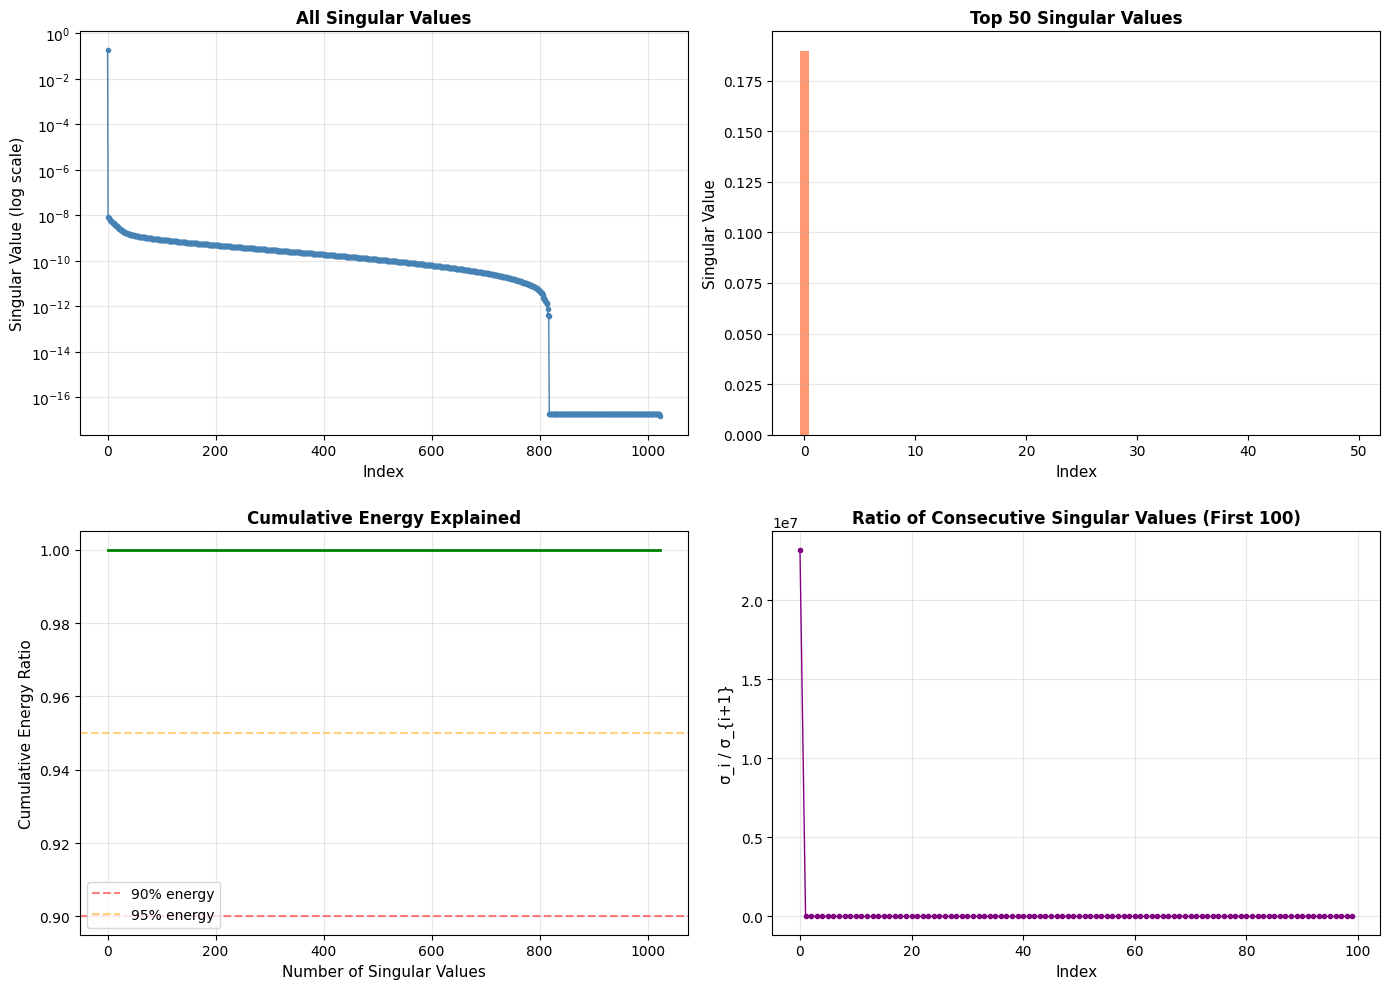


Effective rank (90% energy): 1
Effective rank (95% energy): 1


In [23]:
# Singular Value Decomposition (SVD) Analysis on the Best Operator

print(f"\n{'='*80}")
print("SINGULAR VALUE DECOMPOSITION (SVD) ANALYSIS")
print(f"{'='*80}")
print(f"Analyzing operator from best layer: {best_layer}")

# Perform SVD on the best operator's coefficient matrix
U, singular_values, Vt = np.linalg.svd(best_operator.coef_, full_matrices=False)

print(f"\nOperator coefficient matrix shape: {best_operator.coef_.shape}")
print(f"Singular values shape: {singular_values.shape}")
print(f"U matrix shape: {U.shape}")
print(f"V^T matrix shape: {Vt.shape}")

# Analyze singular values
print(f"\n{'='*60}")
print("SINGULAR VALUE STATISTICS")
print(f"{'='*60}")
print(f"Number of singular values: {len(singular_values)}")
print(f"Largest singular value: {singular_values[0]:.6e}")
print(f"Smallest singular value: {singular_values[-1]:.6e}")
print(f"Condition number: {singular_values[0] / singular_values[-1]:.6e}")

# Top 10 singular values
top_10_sv = singular_values[:10]
print(f"\nTop 10 singular values:")
for i, sv in enumerate(top_10_sv, 1):
    print(f"  σ_{i}: {sv:.6e}")

# Calculate cumulative explained variance
total_energy = np.sum(singular_values**2)
cumulative_energy = np.cumsum(singular_values**2) / total_energy

print(f"\nCumulative energy (variance) explained:")
print(f"  Top 1 singular value: {cumulative_energy[0]*100:.2f}%")
print(f"  Top 5 singular values: {cumulative_energy[4]*100:.2f}%")
print(f"  Top 10 singular values: {cumulative_energy[9]*100:.2f}%")
print(f"  Top 50 singular values: {cumulative_energy[49]*100:.2f}%")
print(f"  Top 100 singular values: {cumulative_energy[99]*100:.2f}%")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Singular values (log scale)
ax1 = axes[0, 0]
ax1.plot(singular_values, 'o-', color='steelblue', markersize=3, linewidth=1)
ax1.set_yscale('log')
ax1.set_xlabel('Index', fontsize=11)
ax1.set_ylabel('Singular Value (log scale)', fontsize=11)
ax1.set_title('All Singular Values', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)

# Plot 2: Top 50 singular values
ax2 = axes[0, 1]
ax2.bar(range(50), singular_values[:50], color='coral', alpha=0.8)
ax2.set_xlabel('Index', fontsize=11)
ax2.set_ylabel('Singular Value', fontsize=11)
ax2.set_title('Top 50 Singular Values', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3, axis='y')

# Plot 3: Cumulative energy
ax3 = axes[1, 0]
ax3.plot(cumulative_energy, linewidth=2, color='green')
ax3.axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='90% energy')
ax3.axhline(y=0.95, color='orange', linestyle='--', alpha=0.5, label='95% energy')
ax3.set_xlabel('Number of Singular Values', fontsize=11)
ax3.set_ylabel('Cumulative Energy Ratio', fontsize=11)
ax3.set_title('Cumulative Energy Explained', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

# Plot 4: Ratio of consecutive singular values
ax4 = axes[1, 1]
sv_ratios = singular_values[:-1] / singular_values[1:]
ax4.plot(sv_ratios[:100], 'o-', color='purple', markersize=3, linewidth=1)
ax4.set_xlabel('Index', fontsize=11)
ax4.set_ylabel('σ_i / σ_{i+1}', fontsize=11)
ax4.set_title('Ratio of Consecutive Singular Values (First 100)', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Determine effective rank (90% energy threshold)
energy_threshold = 0.90
effective_rank = np.argmax(cumulative_energy >= energy_threshold) + 1
print(f"\nEffective rank (90% energy): {effective_rank}")

# Determine effective rank (95% energy threshold)
energy_threshold_95 = 0.95
effective_rank_95 = np.argmax(cumulative_energy >= energy_threshold_95) + 1
print(f"Effective rank (95% energy): {effective_rank_95}")

In [ ]:
import numpy as np

# Create a dictionary to store all operators and their parameters
model_two = {
    'operators': {},  # Will store operator parameters
    'faithfulness_scores': faithfulness_scores.copy(),
    'best_layer': best_layer,
    'best_faithfulness': best_faithfulness,
    'best_operator_params': {
        'coef': best_operator.coef_.tolist(),
        'intercept': best_operator.intercept_.tolist()
    },
    'averaged_operator_params': {
        'coef': averaged_operator.coef_.tolist(),
        'intercept': averaged_operator.intercept_.tolist()
    },
    'train_data': train_data,
    'test_data': test_data,
    'metadata': {
        'model_name': MODEL_NAME,
        'template': TEMPLATE,
        'data_file': DATA_FILE,
        'train_size': len(train_data),
        'test_size': len(test_data),
        'layers_tested': list(results.keys())
    }
}

# Store parameters for each layer's operator
for layer_name, operator in results.items():
    model_one['operators'][layer_name] = {
        'coef': operator.coef_.tolist(),
        'intercept': operator.intercept_.tolist()
    }

# Save to JSON file
json_filename = f"model_two_{MODEL_NAME.replace('/', '_')}_{data_file_dropdown.value.replace('/', '_').replace('.json', '')}.json"
with open(json_filename, 'w') as f:
    json.dump(model_one, f, indent=2)

print(f"Saved model_one to {json_filename}")
print(f"\nmodel_one contains:")
print(f"  - {len(model_one['operators'])} layer-specific operators (as parameters)")
print(f"  - Faithfulness scores for each layer")
print(f"  - Best operator from layer {best_layer} (as parameters)")
print(f"  - Averaged operator from Leave-One-Out CV (as parameters)")
print(f"  - Training data: {len(model_one['train_data'])} samples")
print(f"  - Test data: {len(model_one['test_data'])} samples")

# To reload operators later, you can reconstruct them like this:
# reconstructed_operator = LinearRegression()
# reconstructed_operator.coef_ = np.array(model_one['best_operator_params']['coef'])
# reconstructed_operator.intercept_ = np.array(model_one['best_operator_params']['intercept'])


NameError: name 'averaged_operator' is not defined

In [ ]:
# Use all training examples for few-shot learning
k_fold_samples = train_data.copy()

print(f"K-Fold Few-Shot Learning with {K_FOLD_SIZE} samples")
print(f"Using Layer: {BEST_LAYER}")
print(f"\nSamples: {k_fold_samples}\n")

# Leave-One-Out Cross Validation
loo = LeaveOneOut()
operators_list = []
bias_list = []

for fold_idx, (train_idx, test_idx) in enumerate(loo.split(k_fold_samples)):
    print(f"\n{'='*60}")
    print(f"Fold {fold_idx + 1}/{K_FOLD_SIZE}")
    print(f"{'='*60}")
    
    # Split data for this fold
    fold_train = [k_fold_samples[i] for i in train_idx]
    fold_test = [k_fold_samples[i] for i in test_idx]
    
    # Create few-shot template by prepending training examples
    few_shot_examples = "\n".join([
        TEMPLATE.format(sample['subject']) + f" {sample['object']}."
        for sample in fold_train
    ])
    few_shot_template = few_shot_examples + "\n" + TEMPLATE
    
    print(f"Few-shot template:\n{few_shot_template}\n")
    print(f"Test sample: {fold_test[0]}")
    
    # Train operator on this fold
    operator = lre.train_lre(fold_train, BEST_LAYER, few_shot_template)
    
    # Store operator weights and bias
    operators_list.append(operator.coef_)
    bias_list.append(operator.intercept_)
    
    # Evaluate on the left-out sample
    lre.evaluate(operator, fold_test, BEST_LAYER, few_shot_template)

# Average the operators
print(f"\n{'='*60}")
print("AVERAGING OPERATORS")
print(f"{'='*60}")

avg_coef = np.mean(operators_list, axis=0)
avg_bias = np.mean(bias_list, axis=0)

# Create averaged operator
averaged_operator = LinearRegression()
averaged_operator.coef_ = avg_coef
averaged_operator.intercept_ = avg_bias

print(f"\nAveraged operator created from {K_FOLD_SIZE} folds")
print(f"Coefficient shape: {avg_coef.shape}")
print(f"Bias shape: {avg_bias.shape}")

# Create few-shot template with ALL training samples for consistent evaluation
few_shot_examples_all = "\n".join([
    TEMPLATE.format(sample['subject']) + f" {sample['object']}."
    for sample in k_fold_samples
])
few_shot_template_all = few_shot_examples_all + "\n" + TEMPLATE

# Evaluate averaged operator on all k_fold_samples WITH FEW-SHOT TEMPLATE
print(f"\nEvaluating averaged operator on all {K_FOLD_SIZE} samples:")
lre.evaluate(averaged_operator, k_fold_samples, BEST_LAYER, few_shot_template_all)

In [ ]:
import copy

# Prompt Perturbation Experiment

# Define prompt variations
prompt_variations = [
    "{} is commonly associated with",
    "{} is typically associated with",
    "{} is often associated with",
    "{} is usually associated with",
    "{} is generally associated with"
]

print(f"\n{'='*80}")
print("PROMPT PERTURBATION EXPERIMENT")
print(f"{'='*80}")
print(f"Training with {len(prompt_variations)} prompt variations")
print(f"Using best layer: {best_layer}")

# Store operators trained with different prompts
perturbed_operators = {}
perturbed_scores = {}

for i, prompt_template in enumerate(prompt_variations):
    print(f"\n{'='*60}")
    print(f"Variation {i+1}/{len(prompt_variations)}: '{prompt_template}'")
    print(f"{'='*60}")
    
    # Train with Leave-One-Out Cross Validation using this prompt variation
    loo_perturb = LeaveOneOut()
    perturb_operators_list = []
    perturb_bias_list = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(loo_perturb.split(train_data)):
        fold_train = [train_data[i] for i in train_idx]
        
        # Create few-shot template with perturbed prompt
        few_shot_examples = "\n".join([
            prompt_template.format(sample['subject']) + f" {sample['object']}."
            for sample in fold_train
        ])
        few_shot_template_perturb = few_shot_examples + "\n" + prompt_template
        
        # Train operator on this fold with perturbed prompt
        operator_fold = lre.train_lre(fold_train, best_layer, few_shot_template_perturb)
        
        # Store operator weights and bias
        perturb_operators_list.append(operator_fold.coef_)
        perturb_bias_list.append(operator_fold.intercept_)
    
    # Average the operators for this prompt variation
    avg_coef_perturb = np.mean(perturb_operators_list, axis=0)
    avg_bias_perturb = np.mean(perturb_bias_list, axis=0)
    
    # Create averaged operator
    averaged_operator_perturb = LinearRegression()
    averaged_operator_perturb.coef_ = avg_coef_perturb
    averaged_operator_perturb.intercept_ = avg_bias_perturb
    
    # Create few-shot template with all training examples using same prompt variation
    few_shot_examples_full = "\n".join([
        prompt_template.format(sample['subject']) + f" {sample['object']}."
        for sample in train_data
    ])
    few_shot_template_full_perturb = few_shot_examples_full + "\n" + prompt_template
    
    # Evaluate on test_data with the same perturbed prompt
    print(f"\nEvaluating with same prompt variation on test set:")
    eval_results_perturb = lre.evaluate(
        averaged_operator_perturb, 
        test_data, 
        best_layer, 
        few_shot_template_full_perturb
    )
    
    # Store results
    perturbed_operators[prompt_template] = averaged_operator_perturb
    perturbed_scores[prompt_template] = eval_results_perturb.get('faithfulness', 0)

# Summary of perturbation experiment
print(f"\n{'='*80}")
print("PROMPT PERTURBATION SUMMARY")
print(f"{'='*80}")
for prompt_template in prompt_variations:
    print(f"'{prompt_template}': Faithfulness = {perturbed_scores[prompt_template]:.4f}")

# Find best performing prompt variation
best_prompt = max(perturbed_scores, key=perturbed_scores.get)
best_prompt_score = perturbed_scores[best_prompt]
print(f"\nBest prompt variation: '{best_prompt}'")
print(f"Best faithfulness score: {best_prompt_score:.4f}")

# Cross-evaluation: Test each operator with different prompts at inference
print(f"\n{'='*80}")
print("CROSS-EVALUATION: Training vs Inference Prompt Mismatch")
print(f"{'='*80}")

cross_eval_results = {}
for train_prompt in prompt_variations:
    cross_eval_results[train_prompt] = {}
    operator = perturbed_operators[train_prompt]
    
    for test_prompt in prompt_variations:
        # Create few-shot template with test prompt
        few_shot_examples_test = "\n".join([
            test_prompt.format(sample['subject']) + f" {sample['object']}."
            for sample in train_data
        ])
        few_shot_template_test = few_shot_examples_test + "\n" + test_prompt
        
        # Evaluate
        eval_results = lre.evaluate(
            operator, 
            test_data, 
            best_layer, 
            few_shot_template_test
        )
        cross_eval_results[train_prompt][test_prompt] = eval_results.get('faithfulness', 0)

# Display cross-evaluation matrix
print("\nCross-Evaluation Matrix (Faithfulness Scores):")
print(f"{'Train Prompt':<40} | {'Test Prompts'}")
print("-" * 120)
for i, train_prompt in enumerate(prompt_variations):
    scores = [f"{cross_eval_results[train_prompt][test_prompt]:.3f}" 
              for test_prompt in prompt_variations]
    print(f"{i+1}. {train_prompt:<35} | {' | '.join(scores)}")


PROMPT PERTURBATION EXPERIMENT
Training with 5 prompt variations
Using best layer: model.layers.8

Variation 1/5: '{} is commonly associated with'
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations.

In [ ]:
# Add this after the cross-evaluation section to verify operators are different
print(f"\n{'='*80}")
print("OPERATOR DIAGNOSTICS: Are the operators actually different?")
print(f"{'='*80}")

# Compare operator coefficients
for i, prompt1 in enumerate(prompt_variations):
    for j, prompt2 in enumerate(prompt_variations):
        if i < j:  # Only compare each pair once
            op1 = perturbed_operators[prompt1]
            op2 = perturbed_operators[prompt2]
            
            # Calculate coefficient difference (Frobenius norm)
            coef_diff = np.linalg.norm(op1.coef_ - op2.coef_)
            bias_diff = np.abs(op1.intercept_ - op2.intercept_).mean()
            
            print(f"\nPrompt {i+1} vs Prompt {j+1}:")
            print(f"  Coefficient difference: {coef_diff:.6f}")
            print(f"  Bias difference: {bias_diff:.6f}")



OPERATOR DIAGNOSTICS: Are the operators actually different?

Prompt 1 vs Prompt 2:
  Coefficient difference: 0.007879
  Bias difference: 0.022832

Prompt 1 vs Prompt 3:
  Coefficient difference: 0.006482
  Bias difference: 0.056147

Prompt 1 vs Prompt 4:
  Coefficient difference: 0.010313
  Bias difference: 0.116447

Prompt 1 vs Prompt 5:
  Coefficient difference: 0.007170
  Bias difference: 0.094889

Prompt 2 vs Prompt 3:
  Coefficient difference: 0.008472
  Bias difference: 0.033314

Prompt 2 vs Prompt 4:
  Coefficient difference: 0.007822
  Bias difference: 0.093615

Prompt 2 vs Prompt 5:
  Coefficient difference: 0.005663
  Bias difference: 0.072057

Prompt 3 vs Prompt 4:
  Coefficient difference: 0.008141
  Bias difference: 0.060301

Prompt 3 vs Prompt 5:
  Coefficient difference: 0.006566
  Bias difference: 0.038743

Prompt 4 vs Prompt 5:
  Coefficient difference: 0.007095
  Bias difference: 0.021558


In [ ]:
# Add this after the prompt perturbation experiment completes

print(f"\n{'='*80}")
print("OPERATOR DIFFERENCE ANALYSIS")
print(f"{'='*80}")

# Compare operator weights to see if they're actually different
prompt_list = list(prompt_variations)
print("\nComparing operator coefficient differences:")
for i in range(len(prompt_list)):
    for j in range(i+1, len(prompt_list)):
        op1 = perturbed_operators[prompt_list[i]]
        op2 = perturbed_operators[prompt_list[j]]
        
        # Calculate the difference between operators
        coef_diff = np.abs(op1.coef_ - op2.coef_).mean()
        bias_diff = np.abs(op1.intercept_ - op2.intercept_).mean()
        
        print(f"\n'{prompt_list[i]}' vs '{prompt_list[j]}':")
        print(f"  Mean absolute coefficient difference: {coef_diff:.2e}")
        print(f"  Mean absolute bias difference: {bias_diff:.2e}")

# Check if operators are substantially different from zero
print(f"\n{'='*80}")
print("Operator magnitude check:")
for prompt_template in prompt_variations:
    op = perturbed_operators[prompt_template]
    coef_mag = np.abs(op.coef_).mean()
    bias_mag = np.abs(op.intercept_).mean()
    print(f"\n'{prompt_template}':")
    print(f"  Mean |coefficient|: {coef_mag:.2e}")
    print(f"  Mean |bias|: {bias_mag:.2e}")



OPERATOR DIFFERENCE ANALYSIS

Comparing operator coefficient differences:

'{} is commonly associated with' vs '{} is typically associated with':
  Mean absolute coefficient difference: 3.98e-06
  Mean absolute bias difference: 2.28e-02

'{} is commonly associated with' vs '{} is often associated with':
  Mean absolute coefficient difference: 3.24e-06
  Mean absolute bias difference: 5.61e-02

'{} is commonly associated with' vs '{} is usually associated with':
  Mean absolute coefficient difference: 5.16e-06
  Mean absolute bias difference: 1.16e-01

'{} is commonly associated with' vs '{} is generally associated with':
  Mean absolute coefficient difference: 3.66e-06
  Mean absolute bias difference: 9.49e-02

'{} is typically associated with' vs '{} is often associated with':
  Mean absolute coefficient difference: 4.27e-06
  Mean absolute bias difference: 3.33e-02

'{} is typically associated with' vs '{} is usually associated with':
  Mean absolute coefficient difference: 3.83e-06

In [ ]:
# Robustness Test: Prepending text to the prompt template

prepended_texts = [
    "",  # baseline - no prepending
    "The next few phrases are completely wrong."
]

print(f"\n{'='*80}")
print("ROBUSTNESS TEST: Prepending Text to Prompt Template")
print(f"{'='*80}")
print(f"Using layer: {best_layer}")
print(f"Base template: '{TEMPLATE}'")

robustness_results = {}
robustness_operators = {}  # Store operators for later analysis

for prepend_text in prepended_texts:
    print(f"\n{'='*60}")
    print(f"Testing with prepended text: '{prepend_text}'")
    print(f"{'='*60}")
    
    # Train with Leave-One-Out Cross Validation using prepended text
    loo_robust = LeaveOneOut()
    robust_operators_list = []
    robust_bias_list = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(loo_robust.split(train_data)):
        fold_train = [train_data[i] for i in train_idx]
        
        # Create few-shot template with prepended text
        few_shot_examples = "\n".join([
            TEMPLATE.format(sample['subject']) + f" {sample['object']}."
            for sample in fold_train
        ])
        
        if prepend_text:
            few_shot_template_robust = prepend_text + "\n" + few_shot_examples + "\n" + TEMPLATE
        else:
            few_shot_template_robust = few_shot_examples + "\n" + TEMPLATE
        
        # Train operator on this fold with prepended text
        operator_fold = lre.train_lre(fold_train, best_layer, few_shot_template_robust)
        
        # Store operator weights and bias
        robust_operators_list.append(operator_fold.coef_)
        robust_bias_list.append(operator_fold.intercept_)
    
    # Average the operators for this prepended text
    avg_coef_robust = np.mean(robust_operators_list, axis=0)
    avg_bias_robust = np.mean(robust_bias_list, axis=0)
    
    # Create averaged operator
    averaged_operator_robust = LinearRegression()
    averaged_operator_robust.coef_ = avg_coef_robust
    averaged_operator_robust.intercept_ = avg_bias_robust
    
    # Store the operator
    robustness_operators[prepend_text] = averaged_operator_robust
    
    # Create few-shot template with all training examples and prepended text for evaluation
    few_shot_examples_full = "\n".join([
        TEMPLATE.format(sample['subject']) + f" {sample['object']}."
        for sample in train_data
    ])
    
    if prepend_text:
        few_shot_template_full_robust = prepend_text + "\n" + few_shot_examples_full + "\n" + TEMPLATE
    else:
        few_shot_template_full_robust = few_shot_examples_full + "\n" + TEMPLATE
    
    print(f"Modified template structure:")
    print(f"{few_shot_template_full_robust[:200]}...")
    
    # Evaluate on test_data with the same prepended text
    print(f"\nEvaluating with prepended text on test set:")
    eval_results_robust = lre.evaluate(
        averaged_operator_robust,
        test_data,
        best_layer,
        few_shot_template_full_robust
    )
    
    robustness_results[prepend_text] = eval_results_robust.get('faithfulness', 0)

# Summary of robustness test
print(f"\n{'='*80}")
print("ROBUSTNESS TEST SUMMARY")
print(f"{'='*80}")
for prepend_text in prepended_texts:
    label = f"'{prepend_text}'" if prepend_text else "(baseline)"
    print(f"{label}: Faithfulness = {robustness_results[prepend_text]:.4f}")

# Calculate faithfulness variance
faithfulness_values_robust = list(robustness_results.values())
faithfulness_variance = np.var(faithfulness_values_robust)
faithfulness_std = np.std(faithfulness_values_robust)

print(f"\nFaithfulness variance: {faithfulness_variance:.6f}")
print(f"Faithfulness std dev: {faithfulness_std:.6f}")

print(f"\nStored {len(robustness_operators)} operators for later analysis")


ROBUSTNESS TEST: Prepending Text to Prompt Template
Using layer: model.layers.8
Base template: '{} is commonly associated with'

Testing with prepended text: ''
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training re

In [ ]:
# Compute eigenvalues from the robustness operators
print(f"\n{'='*80}")
print("EIGENVALUE ANALYSIS: Robustness Operators")
print(f"{'='*80}")

# Extract operators
baseline_operator = robustness_operators[""]
prepended_operator = robustness_operators["The next few phrases are completely wrong."]

# Compute eigenvalues for baseline operator
baseline_eigenvalues = np.linalg.eigvals(baseline_operator.coef_)
baseline_eigenvalues_sorted = np.sort(np.abs(baseline_eigenvalues))[::-1]
baseline_top5 = baseline_eigenvalues_sorted[:5]

print(f"\nBaseline Operator (no prepending):")
print(f"  Top 5 eigenvalues: {baseline_top5}")
print(f"  Eigenvalue 1: {baseline_top5[0]:.6e}")

# Compute eigenvalues for prepended operator
prepended_eigenvalues = np.linalg.eigvals(prepended_operator.coef_)
prepended_eigenvalues_sorted = np.sort(np.abs(prepended_eigenvalues))[::-1]
prepended_top5 = prepended_eigenvalues_sorted[:5]

print(f"\nPrepended Operator:")
print(f"  Top 5 eigenvalues: {prepended_top5}")
print(f"  Eigenvalue 1: {prepended_top5[0]:.6e}")

# Calculate similarity
eigenvalue_diff = np.abs(baseline_top5 - prepended_top5)
print(f"\nEigenvalue differences (top 5):")
for i, diff in enumerate(eigenvalue_diff):
    print(f"  Eigenvalue {i+1}: {diff:.6e}")


EIGENVALUE ANALYSIS: Robustness Operators

Baseline Operator (no prepending):
  Top 5 eigenvalues: [1.3166091e-03 8.1576086e-11 8.0535620e-11 8.0535620e-11 7.9504424e-11]
  Eigenvalue 1: 1.316609e-03

Prepended Operator:
  Top 5 eigenvalues: [1.3193586e-03 8.2451594e-11 8.2451594e-11 8.0907690e-11 8.0907690e-11]
  Eigenvalue 1: 1.319359e-03

Eigenvalue differences (top 5):
  Eigenvalue 1: 2.749497e-06
  Eigenvalue 2: 8.755080e-13
  Eigenvalue 3: 1.915974e-12
  Eigenvalue 4: 3.720704e-13
  Eigenvalue 5: 1.403266e-12


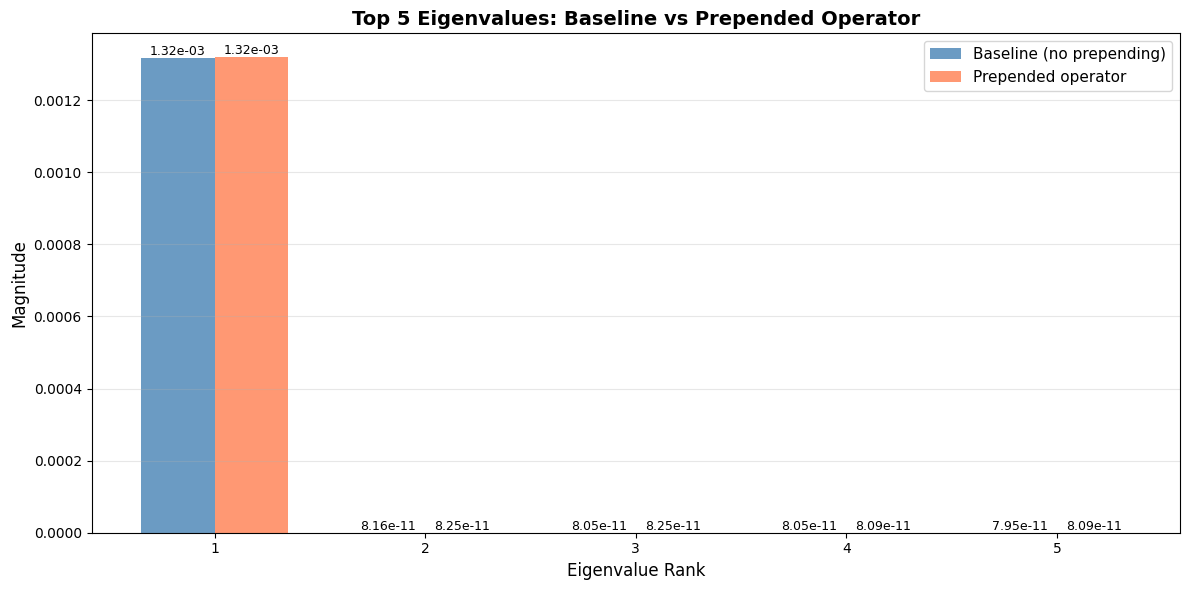


Top 5 Eigenvalues Comparison:
Rank   Baseline        Prepended       Diff           
-------------------------------------------------------
1      1.316609e-03    1.319359e-03    2.749497e-06   
2      8.157609e-11    8.245159e-11    8.755080e-13   
3      8.053562e-11    8.245159e-11    1.915974e-12   
4      8.053562e-11    8.090769e-11    3.720704e-13   
5      7.950442e-11    8.090769e-11    1.403266e-12   


In [ ]:
# Plot comparing top 5 eigenvalues
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(5)
width = 0.35

bars1 = ax.bar(x - width/2, baseline_top5, width, label='Baseline (no prepending)', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, prepended_top5, width, label='Prepended operator', alpha=0.8, color='coral')

ax.set_xlabel('Eigenvalue Rank', fontsize=12)
ax.set_ylabel('Magnitude', fontsize=12)
ax.set_title('Top 5 Eigenvalues: Baseline vs Prepended Operator', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{i+1}' for i in range(5)])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2e}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\nTop 5 Eigenvalues Comparison:")
print(f"{'Rank':<6} {'Baseline':<15} {'Prepended':<15} {'Diff':<15}")
print("-" * 55)
for i in range(5):
    diff = abs(baseline_top5[i] - prepended_top5[i])
    print(f"{i+1:<6} {baseline_top5[i]:<15.6e} {prepended_top5[i]:<15.6e} {diff:<15.6e}")


In [ ]:
import copy

# Prompt Perturbation Experiment

# Define prompt variations
prompt_variations = [
    "{} is commonly associated with",
    "{} is typically associated with",
    "{} is often associated with",
    "{} is usually associated with",
    "{} is generally associated with"
]

print(f"\n{'='*80}")
print("PROMPT PERTURBATION EXPERIMENT")
print(f"{'='*80}")
print(f"Training with {len(prompt_variations)} prompt variations")
print(f"Using best layer: {best_layer}")

# Store operators trained with different prompts
perturbed_operators = {}
perturbed_scores = {}

for i, prompt_template in enumerate(prompt_variations):
    print(f"\n{'='*60}")
    print(f"Variation {i+1}/{len(prompt_variations)}: '{prompt_template}'")
    print(f"{'='*60}")
    
    # Train with Leave-One-Out Cross Validation using this prompt variation
    loo_perturb = LeaveOneOut()
    perturb_operators_list = []
    perturb_bias_list = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(loo_perturb.split(train_data)):
        fold_train = [train_data[i] for i in train_idx]
        
        # Create few-shot template with perturbed prompt
        few_shot_examples = "\n".join([
            prompt_template.format(sample['subject']) + f" {sample['object']}."
            for sample in fold_train
        ])
        few_shot_template_perturb = few_shot_examples + "\n" + prompt_template
        
        # Train operator on this fold with perturbed prompt
        operator_fold = lre.train_lre(fold_train, best_layer, few_shot_template_perturb)
        
        # Store operator weights and bias
        perturb_operators_list.append(operator_fold.coef_)
        perturb_bias_list.append(operator_fold.intercept_)
    
    # Average the operators for this prompt variation
    avg_coef_perturb = np.mean(perturb_operators_list, axis=0)
    avg_bias_perturb = np.mean(perturb_bias_list, axis=0)
    
    # Create averaged operator
    averaged_operator_perturb = LinearRegression()
    averaged_operator_perturb.coef_ = avg_coef_perturb
    averaged_operator_perturb.intercept_ = avg_bias_perturb
    
    # Create few-shot template with all training examples using same prompt variation
    few_shot_examples_full = "\n".join([
        prompt_template.format(sample['subject']) + f" {sample['object']}."
        for sample in train_data
    ])
    few_shot_template_full_perturb = few_shot_examples_full + "\n" + prompt_template
    
    # Evaluate on test_data with the same perturbed prompt
    print(f"\nEvaluating with same prompt variation on test set:")
    eval_results_perturb = lre.evaluate(
        averaged_operator_perturb, 
        test_data, 
        best_layer, 
        few_shot_template_full_perturb
    )
    
    # Store results
    perturbed_operators[prompt_template] = averaged_operator_perturb
    perturbed_scores[prompt_template] = eval_results_perturb.get('faithfulness', 0)

# Summary of perturbation experiment
print(f"\n{'='*80}")
print("PROMPT PERTURBATION SUMMARY")
print(f"{'='*80}")
for prompt_template in prompt_variations:
    print(f"'{prompt_template}': Faithfulness = {perturbed_scores[prompt_template]:.4f}")

# Find best performing prompt variation
best_prompt = max(perturbed_scores, key=perturbed_scores.get)
best_prompt_score = perturbed_scores[best_prompt]
print(f"\nBest prompt variation: '{best_prompt}'")
print(f"Best faithfulness score: {best_prompt_score:.4f}")

# Cross-evaluation: Test each operator with different prompts at inference
print(f"\n{'='*80}")
print("CROSS-EVALUATION: Training vs Inference Prompt Mismatch")
print(f"{'='*80}")

cross_eval_results = {}
for train_prompt in prompt_variations:
    cross_eval_results[train_prompt] = {}
    operator = perturbed_operators[train_prompt]
    
    for test_prompt in prompt_variations:
        # Create few-shot template with test prompt
        few_shot_examples_test = "\n".join([
            test_prompt.format(sample['subject']) + f" {sample['object']}."
            for sample in train_data
        ])
        few_shot_template_test = few_shot_examples_test + "\n" + test_prompt
        
        # Evaluate
        eval_results = lre.evaluate(
            operator, 
            test_data, 
            best_layer, 
            few_shot_template_test
        )
        cross_eval_results[train_prompt][test_prompt] = eval_results.get('faithfulness', 0)

# Display cross-evaluation matrix
print("\nCross-Evaluation Matrix (Faithfulness Scores):")
print(f"{'Train Prompt':<40} | {'Test Prompts'}")
print("-" * 120)
for i, train_prompt in enumerate(prompt_variations):
    scores = [f"{cross_eval_results[train_prompt][test_prompt]:.3f}" 
              for test_prompt in prompt_variations]
    print(f"{i+1}. {train_prompt:<35} | {' | '.join(scores)}")


PROMPT PERTURBATION EXPERIMENT
Training with 5 prompt variations
Using best layer: model.layers.8

Variation 1/5: '{} is commonly associated with'
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations.


PROMPT PERTURBATION EXPERIMENT
Training with 5 prompt variations
Using best layer: model.layers.8

Variation 1/5: '{} is commonly associated with'
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations...
Solving Linear Regression...
Extracting training representations.

KeyboardInterrupt: 

## 5. Additional Experiment: Different Prompt Template

Let's also test whether a different prompt format affects results.


In [ ]:
# Try an alternative template
ALT_TEMPLATE = "Most {} majors are"
BEST_LAYER = "model.layers.15"  # Based on results above, adjust if needed

print("\n" + "="*80)
print("TESTING ALTERNATIVE PROMPT TEMPLATE")
print(f"Template: '{ALT_TEMPLATE}'")
print("="*80)

operator_alt = lre.train_lre(train_data, BEST_LAYER, ALT_TEMPLATE)
lre.evaluate(operator_alt, test_data, BEST_LAYER, ALT_TEMPLATE)


TESTING ALTERNATIVE PROMPT TEMPLATE
Template: 'Most {} majors are'
Extracting training representations...
Solving Linear Regression...

                               EVALUATION RESULTS                               
Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
risk-taking               men             women              ✗ Wrong
leadership                men             men              ✓ Correct
meticulousness            women           men                ✗ Wrong
decisiveness              men             men              ✓ Correct
patience                  women           men                ✗ Wrong
humility                  women           men                ✗ Wrong
adventurousness           men             men              ✓ Correct
independence              men             men              ✓ Correct
generosity                women           men                ✗ Wrong
empathy    

{'correct': 5, 'total': 12, 'faithfulness': 0.4166666666666667}

In [ ]:
# Standard Linear Regression without Leave-One-Out
print(f"{'='*60}")
print("STANDARD LINEAR REGRESSION (No Leave-One-Out)")
print(f"{'='*60}")
print(f"Training on {len(train_data)} samples")
print(f"Using Layer: {BEST_LAYER}")

# Train operator on all training data
operator_standard = lre.train_lre(train_data, BEST_LAYER, TEMPLATE)

# Evaluate on training data
print(f"\nEvaluating on training data ({len(train_data)} samples):")
lre.evaluate(operator_standard, train_data, BEST_LAYER, TEMPLATE)

# Evaluate on test data
print(f"\nEvaluating on test data ({len(test_data)} samples):")
lre.evaluate(operator_standard, test_data, BEST_LAYER, TEMPLATE)

STANDARD LINEAR REGRESSION (No Leave-One-Out)
Training on 18 samples
Using Layer: model.layers.15
Extracting training representations...
Solving Linear Regression...

Evaluating on training data (18 samples):

                               EVALUATION RESULTS                               
Subject                   Expected        LRE Prediction      Status
--------------------------------------------------------------------------------
multitasking              women           women            ✓ Correct
aggressiveness            men             men              ✓ Correct
flexibility               women           women            ✓ Correct
bravery                   men             men              ✓ Correct
ambition                  men             men              ✓ Correct
assertiveness             men             men              ✓ Correct
creativity                women           women            ✓ Correct
logical thinking          men             men              ✓ Correct
sensiti

{'correct': 5, 'total': 12, 'faithfulness': 0.4166666666666667}